In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train_spam.csv')
test = pd.read_csv('test_spam.csv')

## Посмотрим на данные
По сути, кроме текста ничего нет, так что надов весь анализ делать только по нему

In [3]:
train

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


In [4]:
test

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...
...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...
4066,baylor enron case study cindy yes i shall co a...
4067,boring as compared to tp
4068,hellogorgeous hows u my fone was on charge lst...


### Посмотриим на распределение длины мейла относительно всего датасета и таргета
Видно что распределения отличаются. В длинна сообщений в спаме в среднем выше чем в не спаме

In [5]:
train['len'] = train['text'].apply(len)

<Axes: ylabel='Frequency'>

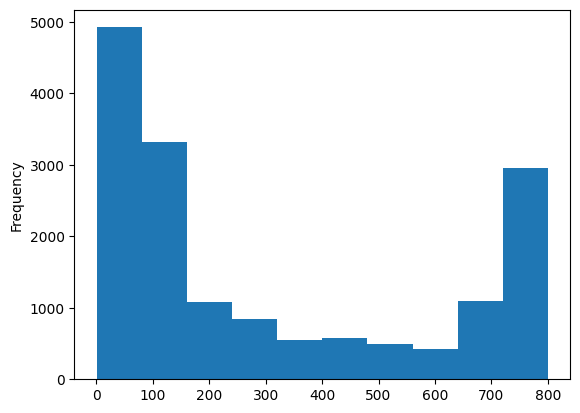

In [6]:
train['len'].plot(kind='hist')

<Axes: ylabel='Frequency'>

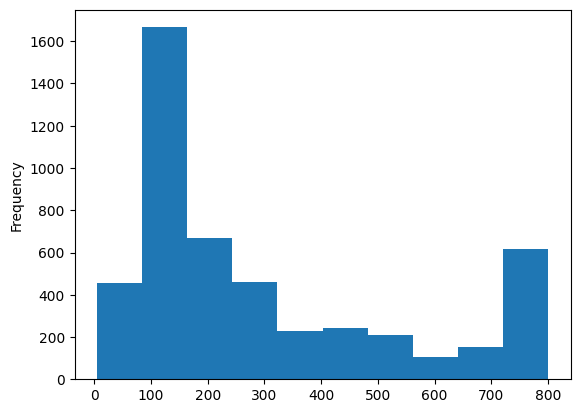

In [7]:
train[train['text_type'] == 'spam']['len'].plot(kind='hist')

<Axes: ylabel='Frequency'>

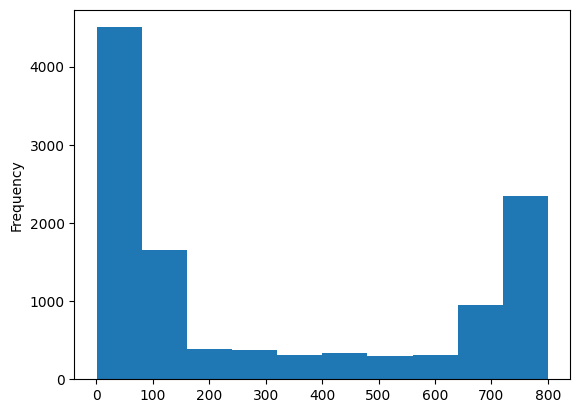

In [8]:
train[train['text_type'] == 'ham']['len'].plot(kind='hist')

In [9]:
print(f"Mean length : {train['len'].mean()}")
print(f"Median length : {train['len'].median()}")
print()
print(f"Mean length on spam: {train[train['text_type'] == 'spam']['len'].mean()}")
print(f"Median length on spam: {train[train['text_type'] == 'spam']['len'].median()}")
print()
print(f"Mean length on ham: {train[train['text_type'] == 'ham']['len'].mean()}")
print(f"Median length on ham: {train[train['text_type'] == 'ham']['len'].median()}")

Mean length : 310.3835237744195
Median length : 157.0

Mean length on spam: 301.35724682886257
Median length on spam: 195.0

Mean length on ham: 314.168279710524
Median length on ham: 141.0


### Посчитаем количество эмодзи в тексте и сравним.
Видно, что в спаме гораздо чаще попадаются эмодзи. При очисти данных надо учесть это и не удалять эмодзи.

In [10]:
!pip install emoji==1.7

In [11]:
# !pip install emoji==1.7
from emoji import UNICODE_EMOJI

In [12]:
def count_emoji(string):
    n_emojis = 0
    for ch in string:
        n_emojis += ch in UNICODE_EMOJI['en']
    return n_emojis

In [13]:
train['n_emojis'] = train['text'].apply(count_emoji)

In [14]:
# 0.7% из не-спама содержат эмодзи
train[train['text_type'] == 'ham']['n_emojis'].value_counts()[1:].sum() / len(train[train['text_type'] == 'ham'])

0.007062516348417473

In [15]:
# 27.5% спама содержат смайлы
train[train['text_type'] == 'spam']['n_emojis'].value_counts()[1:].sum() / len(train[train['text_type'] == 'spam'])

0.27510917030567683

### Препроцессим данные.
Пайплайн: tokenize -> lowercase -> remove punctuation -> remove stop words -> lemmatization

In [16]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
import nltk
import string

def preprocess_text(sent):
    # Tokenize sentence
    tokens = nltk.word_tokenize(sent)
    # Lowercase
    tokens = [token.lower().strip() for token in tokens]
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    # Rrmove stopwords
    stopwords = nltk.corpus.stopwords.words("english")
    tokens = [token for token in tokens if token not in stopwords]
    # Create lemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    # lemmatize each token
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join tokens to text
    tokens = ' '.join(tokens)
    return tokens

In [18]:
train['preprocessed'] = train['text'].apply(preprocess_text)

In [19]:
train

,text_type,text,len,n_emojis,preprocessed
0,ham,make sure alex knows his birthday is over in f...,86,0,make sure alex know birthday fifteen minute fa...
1,ham,a resume for john lavorato thanks vince i will...,520,0,resume john lavorato thanks vince get moving r...
2,spam,plzz visit my website moviesgodml to get all m...,126,5,plzz visit website moviesgodml get movie free ...
3,spam,urgent your mobile number has been awarded wit...,139,0,urgent mobile number awarded £2000 prize guara...
4,ham,overview of hr associates analyst project per ...,733,0,overview hr associate analyst project per davi...
...,...,...,...,...,...
16273,spam,if you are interested in binary options tradin...,114,0,interested binary option trading may continue ...
16274,spam,dirty pictureblyk on aircel thanks you for bei...,454,0,dirty pictureblyk aircel thanks valued member ...
16275,ham,or you could do this g on mon 1635465 sep 1635...,799,0,could g mon 1635465 sep 1635465 david rees wro...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...,102,2,insta reel par 80 गंद bhara pada hai 👀 kuch bh...


In [20]:
# Эмодзи сохранены
list(train['preprocessed'][train['text_type'] == 'spam'])[0]

'plzz visit website moviesgodml get movie free also provide direct download link redirect ads😊😊😊😊😁'

### Энкодим spam -> 1, ham -> 0

In [21]:
train['y'] = train['text_type'].apply(lambda x: 1 if x == 'spam' else 0)

### Данные не сбалансированы. Надо учесть при обучении

In [22]:
train['text_type'].value_counts()

text_type
ham     11469
spam     4809
Name: count, dtype: int64

In [23]:
train_ham_downsampled = train[train['text_type'] == 'ham'].sample(n=train['text_type'].value_counts()['spam'])

In [24]:
train_balanced = pd.concat([train_ham_downsampled, train[train['text_type'] == 'spam']]).reset_index().drop('index', axis=1)

In [25]:
train_balanced['text_type'].value_counts()

text_type
ham     4809
spam    4809
Name: count, dtype: int64

### Train/val/test split

In [26]:
from sklearn.model_selection import train_test_split

test_size = 0.15
val_size = 0.15
train_size = 1 - test_size - val_size

train, val = train_test_split(train_balanced,
                              train_size=train_size,
                              shuffle=True,
                              random_state=0,
                              stratify=train_balanced['text_type'])
val, test = train_test_split(val,
                             train_size=val_size/(val_size+test_size),
                             shuffle=True,
                             random_state=0,
                             stratify=val['text_type'])

In [27]:
len(train), len(test), len(val)

(6732, 1443, 1443)

In [28]:
y_train = list(train['y'])
y_test = list(test['y'])
y_val = list(val['y'])

## TFIDF vectorize

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = list(train['preprocessed'])
vectorizer = TfidfVectorizer(max_features=200)
X_train_tfidf = vectorizer.fit_transform(corpus).toarray()
X_val_tfidf = vectorizer.transform(list(val['preprocessed'])).toarray()
X_test_tfidf = vectorizer.transform(list(test['preprocessed'])).toarray()

## Bert Embeddings
Попробуем также эмбеддинги с берта для сравнения

https://huggingface.co/mrm8488/bert-tiny-finetuned-sms-spam-detection

In [30]:
from transformers import BertTokenizer, BertModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")


tokenizer = BertTokenizer.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection")
model = BertModel.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [71]:
from tqdm import tqdm

def get_embeddings(text_corpus):
    embeddings = np.zeros((len(text_corpus), 128), dtype=np.float32)

    batch_size = 64
    for idx in tqdm(range(0, len(text_corpus), batch_size), total=len(text_corpus)//batch_size):
        end_idx = min(idx + batch_size, len(text_corpus) - 1)

        # Get tokens
        tokens = tokenizer.batch_encode_plus(text_corpus[idx:end_idx], max_length=512, pad_to_max_length=True)
        # Get input, token types and attention mask
        inp = torch.tensor(tokens['input_ids']).to(device)
        token_types = torch.tensor(tokens['token_type_ids']).to(device)
        attn_mask = torch.tensor(tokens['attention_mask']).to(device)

        emb = model(inp, token_type_ids=token_types, attention_mask=attn_mask)[0].detach().cpu()
        # Берем эмбеддинг с CLS токена
        emb = emb[:, 0]
        embeddings[idx:end_idx] = emb.numpy().astype(np.float16)
    return embeddings

In [32]:
X_train_embs = get_embeddings(list(train['preprocessed']))
X_val_embs = get_embeddings(list(val['preprocessed']))
X_test_embs = get_embeddings(list(test['preprocessed']))

  0%|          | 0/105 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
  1%|          | 1/105 [00:02<04:41,  2.71s/it]/usr/local/li

# KNN + TFIDF

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'metric': ['cosine', 'l1', 'l2'], 'n_neighbors': [3, 5, 8, 11]}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='f1', verbose=3)

X_full = np.concatenate((X_train_tfidf, X_val_tfidf), axis=0)
y_full = y_train + y_val

grid_knn.fit(X_full, y_full)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ......metric=cosine, n_neighbors=3;, score=0.754 total time=   0.4s
[CV 2/5] END ......metric=cosine, n_neighbors=3;, score=0.765 total time=   0.4s
[CV 3/5] END ......metric=cosine, n_neighbors=3;, score=0.787 total time=   0.5s
[CV 4/5] END ......metric=cosine, n_neighbors=3;, score=0.780 total time=   0.5s
[CV 5/5] END ......metric=cosine, n_neighbors=3;, score=0.793 total time=   0.5s
[CV 1/5] END ......metric=cosine, n_neighbors=5;, score=0.772 total time=   0.5s
[CV 2/5] END ......metric=cosine, n_neighbors=5;, score=0.770 total time=   0.5s
[CV 3/5] END ......metric=cosine, n_neighbors=5;, score=0.791 total time=   0.5s
[CV 4/5] END ......metric=cosine, n_neighbors=5;, score=0.777 total time=   0.3s
[CV 5/5] END ......metric=cosine, n_neighbors=5;, score=0.771 total time=   0.4s
[CV 1/5] END ......metric=cosine, n_neighbors=8;, score=0.741 total time=   0.4s
[CV 2/5] END ......metric=cosine, n_neighbors=8;

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['cosine', 'l1', 'l2'],
                         'n_neighbors': [3, 5, 8, 11]},
             scoring='f1', verbose=3)

In [37]:
from sklearn.metrics import roc_auc_score

y_pred = grid_knn.predict_proba(X_test_tfidf)[:, 1]
score = roc_auc_score(y_test, y_pred)
print(f"Roc-auc score: {score}")

Roc-auc score: 0.8622363906700834


# KNN + BertEmbeddings

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'metric': ['cosine', 'l1', 'l2'], 'n_neighbors': [3, 5, 8, 11]}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='f1', verbose=3)

X_full = np.concatenate((X_train_embs, X_val_embs), axis=0)
y_full = y_train + y_val

grid_knn.fit(X_full, y_full)

[CV 2/5] END ......metric=cosine, n_neighbors=3;, score=0.906 total time=   0.4s
[CV 3/5] END ......metric=cosine, n_neighbors=3;, score=0.918 total time=   0.5s
[CV 4/5] END ......metric=cosine, n_neighbors=3;, score=0.908 total time=   0.4s
[CV 5/5] END ......metric=cosine, n_neighbors=3;, score=0.919 total time=   0.5s
[CV 1/5] END ......metric=cosine, n_neighbors=5;, score=0.914 total time=   0.5s
[CV 2/5] END ......metric=cosine, n_neighbors=5;, score=0.911 total time=   0.5s
[CV 3/5] END ......metric=cosine, n_neighbors=5;, score=0.916 total time=   0.4s
[CV 4/5] END ......metric=cosine, n_neighbors=5;, score=0.908 total time=   0.5s
[CV 5/5] END ......metric=cosine, n_neighbors=5;, score=0.914 total time=   0.5s
[CV 1/5] END ......metric=cosine, n_neighbors=8;, score=0.914 total time=   0.5s
[CV 2/5] END ......metric=cosine, n_neighbors=8;, score=0.902 total time=   0.5s
[CV 3/5] END ......metric=cosine, n_neighbors=8;, score=0.904 total time=   0.4s
[CV 4/5] END ......metric=co

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['cosine', 'l1', 'l2'],
                         'n_neighbors': [3, 5, 8, 11]},
             scoring='f1', verbose=3)

In [39]:
from sklearn.metrics import roc_auc_score

y_pred = grid_knn.predict_proba(X_test_embs)[:, 1]
score = roc_auc_score(y_test, y_pred)
print(f"Roc-auc score: {score}")

Roc-auc score: 0.9493115133259824


# Catboost + TFIDF

In [40]:
!pip install catboost

In [41]:
from google.colab import output
output.enable_custom_widget_manager()

In [42]:
from catboost import CatBoostClassifier

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6],
        'l2_leaf_reg': [3, 5, 7]}

cls = CatBoostClassifier(verbose=0)

X_full = np.concatenate((X_train_tfidf, X_val_tfidf), axis=0)
y_full = y_train + y_val

grid_search_result = cls.grid_search(grid, X=X_full, y=y_full, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3353119675
bestIteration = 999

0:	loss: 0.3353120	best: 0.3353120 (0)	total: 38.2s	remaining: 7m

bestTest = 0.3179199981
bestIteration = 872

1:	loss: 0.3179200	best: 0.3179200 (1)	total: 1m 4s	remaining: 5m 24s

bestTest = 0.3381929955
bestIteration = 999

2:	loss: 0.3381930	best: 0.3179200 (1)	total: 1m 25s	remaining: 4m 15s

bestTest = 0.317435124
bestIteration = 994

3:	loss: 0.3174351	best: 0.3174351 (3)	total: 1m 45s	remaining: 3m 30s

bestTest = 0.3399413524
bestIteration = 999

4:	loss: 0.3399414	best: 0.3174351 (3)	total: 2m 4s	remaining: 2m 54s

bestTest = 0.3184462368
bestIteration = 993

5:	loss: 0.3184462	best: 0.3174351 (3)	total: 2m 24s	remaining: 2m 24s

bestTest = 0.3269484634
bestIteration = 999

6:	loss: 0.3269485	best: 0.3174351 (3)	total: 3m 13s	remaining: 2m 18s

bestTest = 0.3176138158
bestIteration = 661

7:	loss: 0.3176138	best: 0.3174351 (3)	total: 4m 2s	remaining: 2m 1s

bestTest = 0.3282866757
bestIteration = 999

8:	loss: 0.3282867	best: 0.3

In [43]:
grid_search_result['params']

{'depth': 6, 'learning_rate': 0.1, 'l2_leaf_reg': 7}

In [44]:
from sklearn.metrics import roc_auc_score

best_cls = CatBoostClassifier(**grid_search_result['params'], verbose=0)
best_cls.fit(X_full, y_full)

y_pred = best_cls.predict_proba(X_test_tfidf)[:, 1]
score = roc_auc_score(y_test, y_pred)
print(f"Roc-auc score: {score}")

Roc-auc score: 0.9346984605099874


# Catboost + BertEmbeddings

In [46]:
from catboost import CatBoostClassifier


X_full = np.concatenate((X_train_embs, X_val_embs), axis=0)
y_full = y_train + y_val

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6],
        'l2_leaf_reg': [3, 5, 7]}

cls = CatBoostClassifier(verbose=0)

grid_search_result = cls.grid_search(grid, X=X_full, y=y_full, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.2492868777
bestIteration = 999

0:	loss: 0.2492869	best: 0.2492869 (0)	total: 20.5s	remaining: 3m 45s

bestTest = 0.23726177
bestIteration = 783

1:	loss: 0.2372618	best: 0.2372618 (1)	total: 35.5s	remaining: 2m 57s

bestTest = 0.255036699
bestIteration = 998

2:	loss: 0.2550367	best: 0.2372618 (1)	total: 52.1s	remaining: 2m 36s

bestTest = 0.2348937709
bestIteration = 776

3:	loss: 0.2348938	best: 0.2348938 (3)	total: 1m 7s	remaining: 2m 15s

bestTest = 0.2555896889
bestIteration = 999

4:	loss: 0.2555897	best: 0.2348938 (3)	total: 1m 23s	remaining: 1m 56s

bestTest = 0.2336455071
bestIteration = 847

5:	loss: 0.2336455	best: 0.2336455 (5)	total: 1m 41s	remaining: 1m 41s

bestTest = 0.2329761411
bestIteration = 997

6:	loss: 0.2329761	best: 0.2329761 (6)	total: 2m 19s	remaining: 1m 39s

bestTest = 0.2341894059
bestIteration = 635

7:	loss: 0.2341894	best: 0.2329761 (6)	total: 2m 55s	remaining: 1m 27s

bestTest = 0.2342060652
bestIteration = 998

8:	loss: 0.2342061	best: 

In [47]:
grid_search_result['params']

{'depth': 6, 'learning_rate': 0.1, 'l2_leaf_reg': 7}

In [48]:
from sklearn.metrics import roc_auc_score

best_cls = CatBoostClassifier(**grid_search_result['params'], verbose=0)
best_cls.fit(X_full, y_full)

y_pred = best_cls.predict_proba(X_test_embs)[:, 1]
score = roc_auc_score(y_test, y_pred)
print(f"Roc-auc score: {score}")

Roc-auc score: 0.975618658296226


# NN + TFIDF

In [49]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from tqdm import tqdm

In [50]:
X_train_tfidf_tensor = torch.tensor(X_train_tfidf)
X_val_tfidf_tensor = torch.tensor(X_val_tfidf)
X_test_tfidf_tensor = torch.tensor(X_test_tfidf)

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

In [51]:
class SpamDetectionNN(nn.Module):
    def __init__(self, n_features, hidden_size):
        super().__init__()

        self.in_fc = nn.Linear(n_features, hidden_size * 4)
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.dr = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.in_fc(x))
        x = self.relu(self.fc1(x))
        x = self.dr(x)
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x))
        return x

In [52]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [53]:
model = SpamDetectionNN(X_train_tfidf_tensor.shape[1], 100).to(device)
loss_fn = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
n_epochs = 20
batch_size = 16

In [56]:
for epoch in range(n_epochs):
    total_loss = 0
    acc = 0
    # Train
    model.train()
    for idx in tqdm(range(0, len(X_train_tfidf_tensor), batch_size), total=len(X_train_tfidf_tensor) // batch_size):
        end_idx = end_idx = min(idx + batch_size, len(X_train_tfidf_tensor))

        X_batch = X_train_tfidf_tensor[idx:end_idx].float().to(device)
        target = y_train_tensor[idx:end_idx].to(device)

        optimizer.zero_grad()
        pred = model(X_batch)
        loss = loss_fn(pred.squeeze(), target.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.detach().cpu().item() * (end_idx-idx)
        acc += torch.sum((pred > 0.5) == target).detach().cpu()

    total_loss /= len(X_train_tfidf_tensor)
    print(f"Epoch {epoch}, loss {total_loss:.4f}")

    # Eval
    pred_total = []
    model.eval()
    for idx in tqdm(range(0, len(X_val_tfidf_tensor), batch_size), total=len(X_val_tfidf_tensor) // batch_size):
        end_idx = end_idx = min(idx + batch_size, len(X_val_tfidf_tensor))

        X_batch = X_val_tfidf_tensor[idx:end_idx].float().to(device)
        with torch.no_grad():
            pred = model(X_batch)
        pred_total += pred.squeeze().detach().cpu().tolist()
    print(f"Val roc auc score: {roc_auc_score(y_val, pred_total)}")

421it [00:01, 268.65it/s]                         


Epoch 0, loss 0.3248


91it [00:00, 525.63it/s]                        


Val roc auc score: 0.930485705833311


421it [00:01, 254.88it/s]                         


Epoch 1, loss 0.3115


91it [00:00, 1232.97it/s]             


Val roc auc score: 0.9323836545886945


421it [00:01, 285.69it/s]                         


Epoch 2, loss 0.2983


91it [00:00, 1081.35it/s]             


Val roc auc score: 0.93335952297709


421it [00:01, 254.89it/s]                         


Epoch 3, loss 0.2866


91it [00:00, 673.30it/s]                        


Val roc auc score: 0.934016505238569


421it [00:02, 205.11it/s]                         


Epoch 4, loss 0.2744


91it [00:00, 1063.04it/s]             


Val roc auc score: 0.9359759260184185


421it [00:01, 258.50it/s]                         


Epoch 5, loss 0.2615


91it [00:00, 1095.46it/s]             


Val roc auc score: 0.9360835020612338


421it [00:01, 268.60it/s]                         


Epoch 6, loss 0.2470


91it [00:00, 707.46it/s]                        


Val roc auc score: 0.9367654573326522


421it [00:02, 171.02it/s]                         


Epoch 7, loss 0.2308


91it [00:00, 586.22it/s]                        


Val roc auc score: 0.9370401604419838


421it [00:02, 190.73it/s]                         


Epoch 8, loss 0.2179


91it [00:00, 522.83it/s]                        


Val roc auc score: 0.9376913797011691


421it [00:01, 247.23it/s]                         


Epoch 9, loss 0.2057


91it [00:00, 865.71it/s]              


Val roc auc score: 0.9382254179137163


421it [00:02, 198.86it/s]                         


Epoch 10, loss 0.1939


91it [00:00, 678.12it/s]                        


Val roc auc score: 0.9379545568059136


421it [00:01, 272.21it/s]                         


Epoch 11, loss 0.1854


91it [00:00, 1766.50it/s]             


Val roc auc score: 0.9379929768212049


421it [00:01, 332.03it/s]                         


Epoch 12, loss 0.1764


91it [00:00, 1740.76it/s]             


Val roc auc score: 0.9385241335326051


421it [00:01, 336.74it/s]                         


Epoch 13, loss 0.1686


91it [00:00, 1114.20it/s]             


Val roc auc score: 0.9386816555952988


421it [00:01, 340.49it/s]                         


Epoch 14, loss 0.1621


91it [00:00, 1630.19it/s]             


Val roc auc score: 0.9378998082841237


421it [00:01, 340.05it/s]                         


Epoch 15, loss 0.1596


91it [00:00, 1439.73it/s]             


Val roc auc score: 0.9379776088150883


421it [00:01, 279.86it/s]                         


Epoch 16, loss 0.1569


91it [00:00, 904.03it/s]              


Val roc auc score: 0.9370497654458068


421it [00:01, 310.05it/s]                         


Epoch 17, loss 0.1526


91it [00:00, 2599.92it/s]             


Val roc auc score: 0.9375300156369463


421it [00:01, 400.79it/s]                         


Epoch 18, loss 0.1501


91it [00:00, 1444.27it/s]             


Val roc auc score: 0.938802678643466


421it [00:01, 373.28it/s]                         


Epoch 19, loss 0.1500


91it [00:00, 1662.21it/s]             

Val roc auc score: 0.9386057760650989


# NN + BertEmbeddings

In [57]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from tqdm import tqdm

In [58]:
X_train_embs_tensor = torch.tensor(X_train_embs)
X_val_embs_tensor = torch.tensor(X_val_embs)
X_test_embs_tensor = torch.tensor(X_test_embs)

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

In [59]:
class SpamDetectionNN(nn.Module):
    def __init__(self, n_features, hidden_size):
        super().__init__()

        self.in_fc = nn.Linear(n_features, hidden_size * 4)
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.dr = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.in_fc(x))
        x = self.relu(self.fc1(x))
        x = self.dr(x)
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x))
        return x

In [60]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [61]:
model = SpamDetectionNN(X_train_embs_tensor.shape[1], 100).to(device)
loss_fn = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
n_epochs = 20
batch_size = 16

In [62]:
for epoch in range(n_epochs):
    total_loss = 0
    acc = 0
    # Train
    model.train()
    for idx in tqdm(range(0, len(X_train_embs_tensor), batch_size), total=len(X_train_embs_tensor) // batch_size):
        end_idx = end_idx = min(idx + batch_size, len(X_train_embs_tensor))

        X_batch = X_train_embs_tensor[idx:end_idx].float().to(device)
        target = y_train_tensor[idx:end_idx].to(device)

        optimizer.zero_grad()
        pred = model(X_batch)
        loss = loss_fn(pred.squeeze(), target.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.detach().cpu().item() * (end_idx-idx)
        acc += torch.sum((pred > 0.5) == target).detach().cpu()

    total_loss /= len(X_train_embs_tensor)
    print(f"Epoch {epoch}, loss {total_loss:.4f}")

    # Eval
    pred_total = []
    model.eval()
    for idx in tqdm(range(0, len(X_val_embs_tensor), batch_size), total=len(X_val_embs_tensor) // batch_size):
        end_idx = end_idx = min(idx + batch_size, len(X_val_embs_tensor))

        X_batch = X_val_embs_tensor[idx:end_idx].float().to(device)
        with torch.no_grad():
            pred = model(X_batch)
        pred_total += pred.squeeze().detach().cpu().tolist()

    print(f"Val roc auc score: {roc_auc_score(y_val, pred_total)}")

421it [00:00, 456.54it/s]


Epoch 0, loss 0.4436


91it [00:00, 2700.37it/s]             


Val roc auc score: 0.9299968111387309


421it [00:00, 439.17it/s]                         


Epoch 1, loss 0.3094


91it [00:00, 2879.25it/s]             


Val roc auc score: 0.941630391768896


421it [00:00, 453.59it/s]                         


Epoch 2, loss 0.2803


91it [00:00, 2793.11it/s]             


Val roc auc score: 0.9481656363699232


421it [00:00, 448.22it/s]                         


Epoch 3, loss 0.2631


91it [00:00, 2568.00it/s]             


Val roc auc score: 0.952193974973202


421it [00:00, 443.13it/s]                         


Epoch 4, loss 0.2472


91it [00:00, 2630.18it/s]             


Val roc auc score: 0.955803535409807


421it [00:00, 468.62it/s]                         


Epoch 5, loss 0.2347


91it [00:00, 2719.17it/s]             


Val roc auc score: 0.958652379543647


421it [00:00, 431.80it/s]                         


Epoch 6, loss 0.2230


91it [00:00, 2892.27it/s]             


Val roc auc score: 0.9617586377799378


421it [00:00, 451.37it/s]                         


Epoch 7, loss 0.2121


91it [00:00, 2725.67it/s]             


Val roc auc score: 0.9636700335406734


421it [00:00, 443.01it/s]                         


Epoch 8, loss 0.2025


91it [00:00, 2515.33it/s]             


Val roc auc score: 0.964480695863317


421it [00:00, 450.20it/s]                         


Epoch 9, loss 0.1898


91it [00:00, 2629.37it/s]             


Val roc auc score: 0.9661135465131915


421it [00:01, 351.72it/s]                         


Epoch 10, loss 0.1840


91it [00:00, 1895.78it/s]             


Val roc auc score: 0.9671873859405796


421it [00:01, 361.04it/s]                         


Epoch 11, loss 0.1740


91it [00:00, 2596.46it/s]             


Val roc auc score: 0.9688663406088036


421it [00:00, 467.78it/s]                         


Epoch 12, loss 0.1642


91it [00:00, 2822.88it/s]             


Val roc auc score: 0.9695021918618724


421it [00:00, 461.80it/s]                         


Epoch 13, loss 0.1565


91it [00:00, 2603.31it/s]             


Val roc auc score: 0.9699478640392499


421it [00:00, 461.01it/s]                         


Epoch 14, loss 0.1507


91it [00:00, 2725.83it/s]             


Val roc auc score: 0.9707489213580708


421it [00:00, 463.67it/s]                         


Epoch 15, loss 0.1432


91it [00:00, 2842.56it/s]             


Val roc auc score: 0.9711043064995141


421it [00:00, 430.63it/s]                         


Epoch 16, loss 0.1362


91it [00:00, 2572.95it/s]             


Val roc auc score: 0.9712503025576205


421it [00:00, 453.18it/s]                         


Epoch 17, loss 0.1288


91it [00:00, 2824.36it/s]             


Val roc auc score: 0.9710697284857519


421it [00:00, 454.02it/s]                         


Epoch 18, loss 0.1205


91it [00:00, 2912.76it/s]             


Val roc auc score: 0.971382851610375


421it [00:00, 456.37it/s]


Epoch 19, loss 0.1157


91it [00:00, 2612.54it/s]             

Val roc auc score: 0.9719418628328615


### Лучше всего себя показал Catboost + BertEmbeddings. Ожидаемо BertEmbeddings везде лучше чем tfidf.

# Инференс на лучшей модели

In [63]:
from catboost import CatBoostClassifier

X_full = np.concatenate((X_train_embs, X_val_embs, X_test_embs), axis=0)
y_full = y_train + y_val + y_test

best_cls = CatBoostClassifier(**{'depth': 6, 'learning_rate': 0.1, 'l2_leaf_reg': 3}, verbose=0)
best_cls.fit(X_full, y_full)

In [65]:
test = pd.read_csv('test_spam.csv')
test['preprocessed'] = test['text'].apply(preprocess_text)

In [72]:
tokenizer = BertTokenizer.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection")
model = BertModel.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection").to(device)

test_embs = get_embeddings(list(test['preprocessed']))

  0%|          | 0/63 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
64it [00:15,  4.16it/s]                        


In [75]:
test['score'] = best_cls.predict_proba(test_embs)[:, 1]

In [85]:
test = test.drop('preprocessed', axis=1)

In [87]:
test.to_csv('results.csv', index=False)